In [26]:
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import glob
import os
import torch.nn as nn
import random
import torch
import numpy as np
import librosa
import torchaudio
import pdb

class ToTensor(object):
    def __call__(self, x, tensor_type='float'):
        if tensor_type == 'float':
            return torch.FloatTensor(x)
        elif tensor_type == 'int':
            return torch.IntTensor(x)


class BatchInfo(object):
    def __init__(self, noisy, clean, frame_num_list, wav_len_list):
        self.feats = noisy
        self.labels = clean
        self.frame_num_list = frame_num_list
        self.wav_len_list = wav_len_list


class CustomCollate(object):
    def __init__(self):
        self.win_size = 320
        self.fft_num = 320
        self.win_shift = 160
        # self.device = opt.device

    @staticmethod
    def normalize(x):
        return x / np.max(abs(x))

    # return {
    #     'noisy_speech': noisy,
    #     'clean_speech': clean,
    #     'frame_num': frame_num,
    #     'wav_len': wav_len
    # }

    def collate_fn(self, batch):
        noisy_list, clean_list, frame_num_list, wav_len_list, wav_name_list, scaling_list = [], [], [], [], [], []
        to_tensor = ToTensor()
        for sample in batch:
            pdb.set_trace()
            c = torch.sqrt(len(sample['noisy_speech'].squeeze()) / torch.sum(sample['noisy_speech'].squeeze() ** 2.0))
            scaling_list.append(c)
            noisy_list.append(to_tensor(sample['noisy_speech'] * c))
            clean_list.append(to_tensor(sample['clean_speech'] * c))
            frame_num_list.append(sample['frame_num'])
            wav_len_list.append(sample['wav_len'])
            wav_name_list.append(sample['wav_name'])
        noisy_list = nn.utils.rnn.pad_sequence(noisy_list, batch_first=True)
        clean_list = nn.utils.rnn.pad_sequence(clean_list, batch_first=True)  # [b, chunk_length]
        noisy_list = torch.stft(
            noisy_list,
            n_fft=self.fft_num,
            hop_length=self.win_shift,
            win_length=self.win_size,
            window=torch.hann_window(self.fft_num),
            return_complex=False
        ).permute(0, 3, 2, 1)  # [b, 2, T, F] real tensor, return_complex = false
        clean_list = torch.stft(
            clean_list,
            n_fft=self.fft_num,
            hop_length=self.win_shift,
            win_length=self.win_size,
            window=torch.hann_window(self.fft_num),
            return_complex=False
        ).permute(0, 3, 2, 1)  # [b, 2, T, F]

        return {
            'feats': noisy_list,
            'labels': clean_list,
            'frame_num_list': frame_num_list,
            'wav_len_list': wav_len_list,
            'wav_name_list': wav_name_list,
            'scaling_list': scaling_list
        }


class VBDataset(Dataset):
    def __init__(self, noisy_root, clean_root, data_type):
        super(VBDataset, self).__init__()
        self.noisy_root = noisy_root
        self.clean_root = clean_root
        self.chunk_length = 48000
        self.win_size = 320
        self.fft_num = 320
        self.win_shift = 160
        self.raw_paths = [x.split('/')[-1] for x in glob.glob(noisy_root + '/*.wav')]

        assert data_type in ['train', 'valid', 'test']
        self.data_type = data_type  # determine train or test
        
        ori_sr = 16000 if False else 48000
        self.resample = torchaudio.transforms.Resample(ori_sr, 16000)

    def __len__(self):
        return len(self.raw_paths)

    def __getitem__(self, index):
        wav_name = self.raw_paths[index]
        # pdb.set_trace()
        noisy, n_sr = torchaudio.load(os.path.join(self.noisy_root, self.raw_paths[index]))
        noisy = self.resample(noisy)
        # noisy2 = torchaudio.transforms.Resample(noisy, n_sr, 16000)
        clean, c_sr = torchaudio.load(os.path.join(self.clean_root, self.raw_paths[index]))
        clean = self.resample(clean)
        # clean2 = torchaudio.transforms.Resample(clean, c_sr, 16000)
        # noisy2, _ = librosa.load(os.path.join(self.noisy_root, self.raw_paths[index]), sr=16000)
        # clean2, _ = librosa.load(os.path.join(self.clean_root, self.raw_paths[index]), sr=16000)
        if self.data_type == 'train':
            if len(noisy) > self.chunk_length:
                wav_start = random.randint(0, len(noisy) - self.chunk_length)
                noisy = noisy[wav_start:wav_start + self.chunk_length]
                clean = clean[wav_start:wav_start + self.chunk_length]
        wav_len = len(noisy)
        frame_num = (len(noisy) - self.win_size + self.fft_num) // self.win_shift + 1
        # return noisy, clean, frame_num, wav_len
        return {
            'noisy_speech': noisy,
            'clean_speech': clean,
            'frame_num': frame_num,
            'wav_len': wav_len,
            'wav_name': wav_name
        }

In [27]:
tr_data = VBDataset(
    f'./data/voicebank/noisy_trainset_remove_val_wav',
    f'./data/voicebank/clean_trainset_remove_val_wav',
    'train')

train_loader = DataLoader(tr_data, batch_size=32, shuffle=True, drop_last=True,
                                pin_memory=True, collate_fn=CustomCollate().collate_fn, num_workers=0)#, prefetch_factor=2)

In [28]:
import time, datetime

st = time.time()
for datas in tqdm(train_loader):
    pass
ed = time.time()

print(f'{datetime.timedelta(seconds=ed-st)}')


  0%|          | 0/337 [00:00<?, ?it/s]

> /tmp/ipykernel_22111/517259678.py(53)collate_fn()
     51         for sample in batch:
     52             pdb.set_trace()
---> 53             c = torch.sqrt(len(sample['noisy_speech'].squeeze()) / torch.sum(sample['noisy_speech'].squeeze() ** 2.0))
     54             scaling_list.append(c)
     55             noisy_list.append(to_tensor(sample['noisy_speech'] * c))

> /tmp/ipykernel_22111/517259678.py(54)collate_fn()
     52             pdb.set_trace()
     53             c = torch.sqrt(len(sample['noisy_speech'].squeeze()) / torch.sum(sample['noisy_speech'].squeeze() ** 2.0))
---> 54             scaling_list.append(c)
     55             noisy_list.append(to_tensor(sample['noisy_speech'] * c))
     56             clean_list.append(to_tensor(sample['clean_speech'] * c))

tensor(20.4117)
> /tmp/ipykernel_22111/517259678.py(55)collate_fn()
     53             c = torch.sqrt(len(sample['noisy_speech'].squeeze()) / torch.sum(sample['noisy_speech'].squeeze() ** 2.0))
     54            

  0%|          | 0/337 [01:11<?, ?it/s]


In [5]:
import time, datetime
start=10
end = 20
print(f'Epoch [] time consuming... {datetime.timedelta(seconds=end-start)} sec')
# print(f'{end-start:.5f}')

Epoch [] time consuming... 0:00:10 sec


In [64]:
import torch
import numpy as np
temp = torch.rand(1, 2)
ft = torch.FloatTensor((1, 2))


In [4]:
import os, glob
import librosa

# chime4 = 180947444
# vb =      45688681
files = glob.glob('/mnt/ssd_mnt/kkr/DR-DiffuSE/data/voicebank/noisy_testset_wav/*')

total = 0
for file in files:
    sd, _ = librosa.load(file)
    total += len(sd)
    
print(total)

# 3.1414486

45688681


In [2]:
import torch
import torch.nn as nn

# 입력 데이터의 크기: (배치 크기, 채널, 높이, 너비)
input_size = (64, 3, 32, 32)

# Conv2d 레이어 정의
conv = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)

# 입력 데이터 생성
input_data = torch.randn(input_size)

# 컨볼루션 연산 수행
output = conv(input_data)

# 출력 데이터의 크기 출력
print("Output size:", output.size())


Output size: torch.Size([64, 64, 32, 32])


/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
import torch

ckpt = torch.load('/mnt/ssd_mnt/kkr/DR-DiffuSE/results/DB_AIAT/pretrained/vb_aia_merge_new.pth')
# print(ckpt['step'])

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
len(ckpt.keys())

337

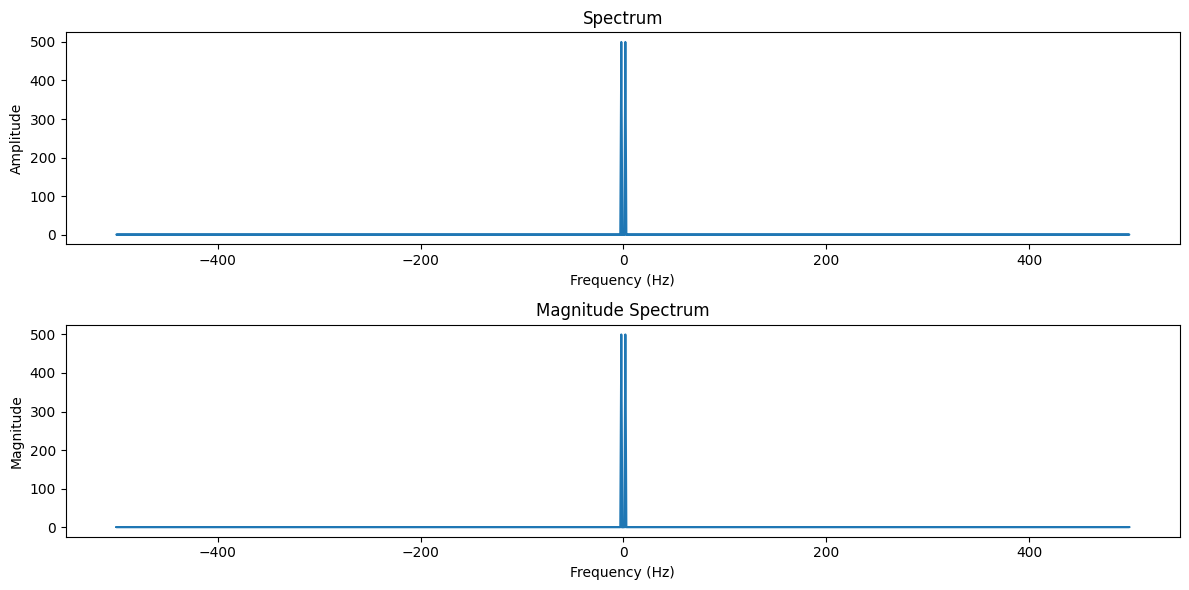

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft

# 파형 생성 (예: 2Hz의 사인파)
fs = 1000  # 샘플링 주파수
t = np.arange(0, 1, 1/fs)  # 1초 동안의 시간 배열
signal = np.sin(2 * np.pi * 2 * t)  # 2Hz의 사인파 생성

# 스펙트럼 계산
spectrum = fft(signal)
frequencies = np.fft.fftfreq(len(spectrum), 1/fs)

# 크기 스펙트럼 계산
magnitude_spectrum = np.abs(spectrum)

# 시각화
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(frequencies, np.abs(spectrum))
plt.title('Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(frequencies, magnitude_spectrum)
plt.title('Magnitude Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()

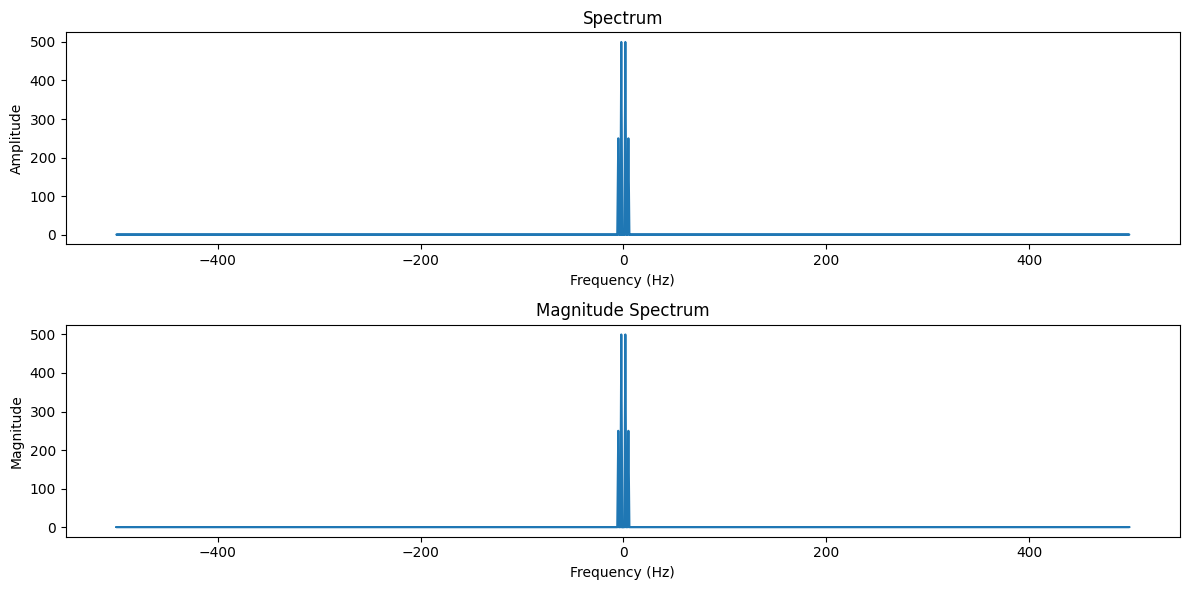

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft

# 파형 생성 (예: 2Hz와 5Hz의 사인파 조합)
fs = 1000  # 샘플링 주파수
t = np.arange(0, 1, 1/fs)  # 1초 동안의 시간 배열
signal = np.sin(2 * np.pi * 2 * t) + 0.5 * np.sin(2 * np.pi * 5 * t)  # 2Hz와 5Hz의 사인파 조합 생성

# 스펙트럼 계산
spectrum = fft(signal)
frequencies = np.fft.fftfreq(len(spectrum), 1/fs)

# 크기 스펙트럼 계산
magnitude_spectrum = np.abs(spectrum)

# 시각화
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(frequencies,np.abs(spectrum))
plt.title('Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(frequencies, magnitude_spectrum)
plt.title('Magnitude Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()

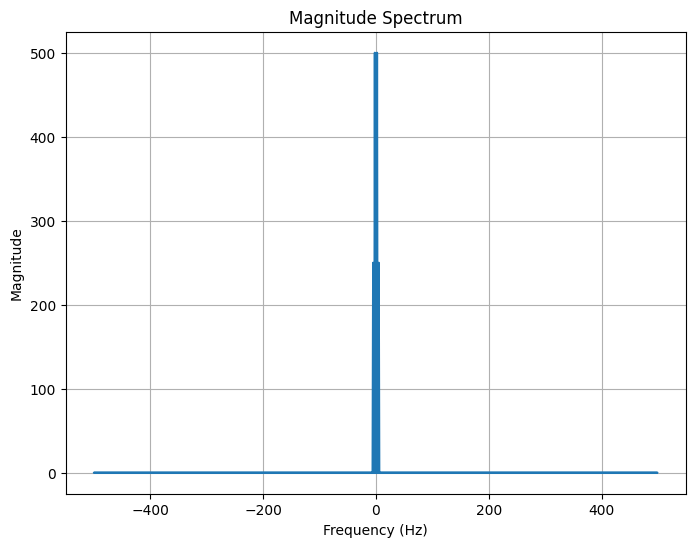

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft

# 파형 생성 (예: 2Hz와 5Hz의 사인파 조합)
fs = 1000  # 샘플링 주파수
t = np.arange(0, 1, 1/fs)  # 1초 동안의 시간 배열
signal = np.sin(2 * np.pi * 2 * t) + 0.5 * np.sin(2 * np.pi * 5 * t)  # 2Hz와 5Hz의 사인파 조합 생성

# 크기 스펙트럼 계산
magnitude_spectrum = np.abs(fft(signal))
frequencies = np.fft.fftfreq(len(magnitude_spectrum), 1/fs)

# 시각화
plt.figure(figsize=(8, 6))

plt.plot(frequencies, magnitude_spectrum)
plt.title('Magnitude Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.show()


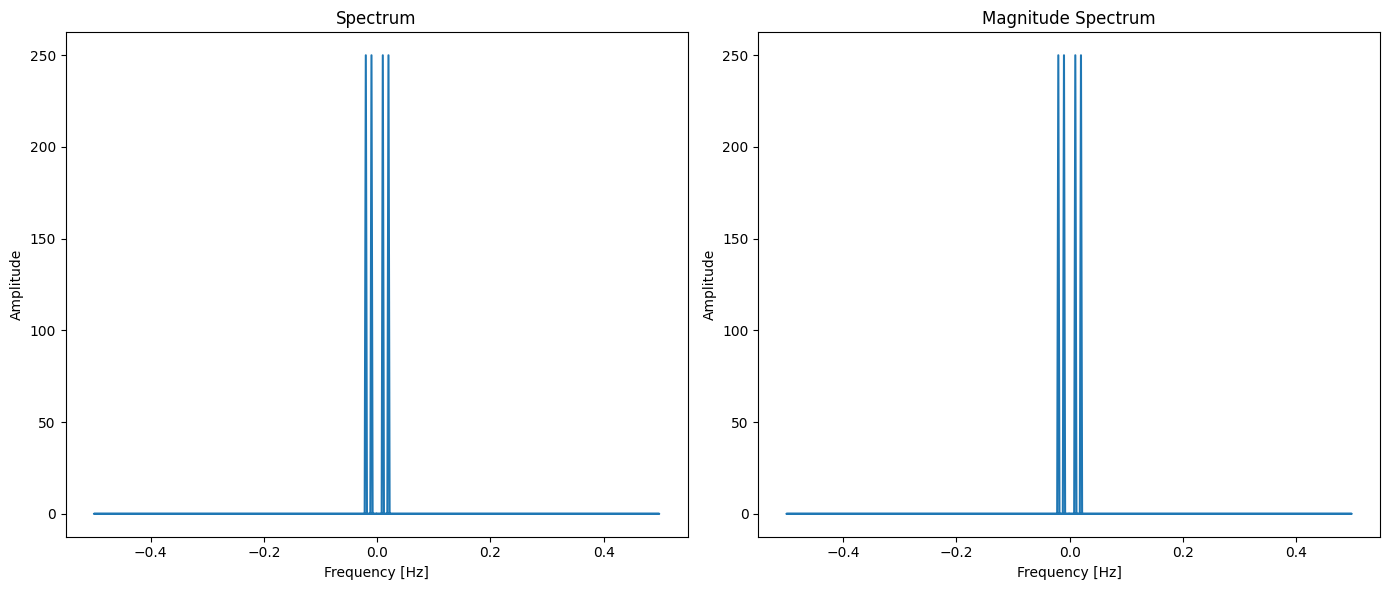

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# 시간 도메인에서의 신호 생성
t = np.linspace(0, 1, 500, endpoint=False)
signal = np.cos(2 * np.pi * 5 * t) + np.sin(2 * np.pi * 10 * t)

# FFT를 사용하여 Spectrum 계산
spectrum = np.fft.fft(signal)

# Magnitude Spectrum 계산
magnitude_spectrum = np.abs(spectrum)

# Spectrum 그래프 그리기
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(np.fft.fftfreq(len(t)), np.abs(spectrum))
plt.title('Spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

# Magnitude Spectrum 그래프 그리기
plt.subplot(1, 2, 2)
plt.plot(np.fft.fftfreq(len(t)), magnitude_spectrum)
plt.title('Magnitude Spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


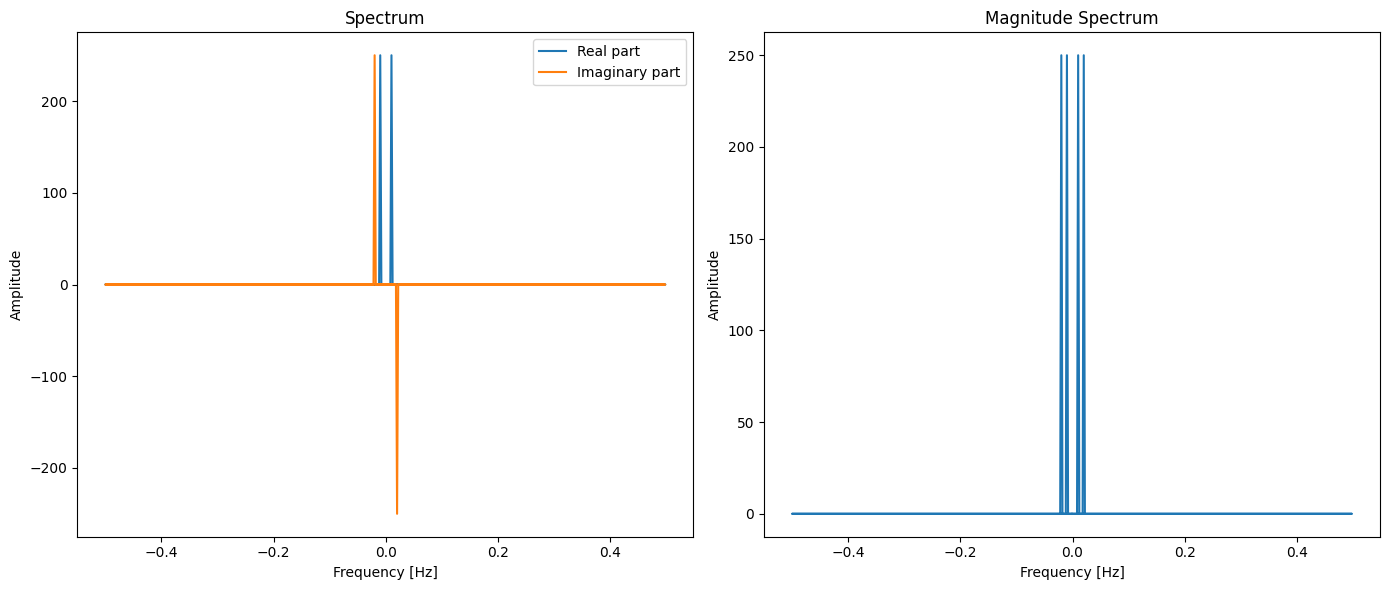

In [8]:
# Spectrum 그래프 그리기 (실수 부분과 허수 부분)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(np.fft.fftfreq(len(t)), spectrum.real, label='Real part')
plt.plot(np.fft.fftfreq(len(t)), spectrum.imag, label='Imaginary part')
plt.title('Spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.legend()

# Magnitude Spectrum 그래프 그리기
plt.subplot(1, 2, 2)
plt.plot(np.fft.fftfreq(len(t)), magnitude_spectrum)
plt.title('Magnitude Spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


In [9]:
import numpy as np
from scipy.fft import fft

# 음성 신호 예시 (임의의 값)
voice_signal = np.random.normal(0, 1, 1000)

# FFT 적용
spectrum = fft(voice_signal)

# 크기와 위상 계산
magnitude = np.abs(spectrum)
phase = np.angle(spectrum)


In [22]:
phase

array([-3.14159265,  1.24674327, -3.05066369, -1.69322379, -3.06426045,
       -2.31892643, -1.34859371, -0.23806622,  0.9637099 ,  3.10708538,
       -0.39201043, -0.69321501, -1.01934284, -2.27559434,  1.92246332,
        1.62507208, -2.28870497,  1.47130687,  1.66665794, -2.86336499,
       -2.95336156, -1.56393379, -1.54438174,  1.55511355, -2.54376399,
        1.23358615, -2.37271059, -0.46624024, -1.72570197,  1.09397278,
       -3.00172066, -0.92468319, -1.3577842 ,  3.0836854 , -1.1462876 ,
       -1.44148086,  2.85715452, -1.69916757, -1.1554369 , -2.41572921,
        0.16713939,  0.84184487,  2.693384  ,  0.24957241,  2.95129635,
       -1.93659686, -2.6869924 , -0.57397595,  1.51833251,  2.35106223,
       -1.27468922, -0.61657948, -3.02615821,  3.12503199,  0.56681996,
       -1.76202388, -2.58137701, -1.68362113,  2.97695516,  2.89362674,
       -1.44846943, -0.73444164, -2.17868362, -0.4835772 , -2.84216893,
        1.22422814,  0.23871117,  1.86026446,  0.36314413,  0.85

In [21]:
phase * 180 / np.pi

array([-180.        ,   71.4331275 , -174.79015389,  -97.01457684,
       -175.56919096, -132.86469749,  -77.26872808,  -13.64018986,
         55.21650981,  178.02287871,  -22.46054339,  -39.71829464,
        -58.40404252, -130.38195177,  110.14903447,   93.10977144,
       -131.1331356 ,   84.29967409,   95.49246557, -164.05872904,
       -169.21515287,  -89.60680551,  -88.48655593,   89.10144331,
       -145.74694095,   70.67927989, -135.94630285,  -26.71359804,
        -98.87543956,   62.68002334, -171.98592488,  -52.98044402,
        -77.79530419,  176.68215888,  -65.67744131,  -82.59076964,
        163.70289552,  -97.35513058,  -66.2016579 , -138.41108799,
          9.57638179,   48.23415795,  154.31953593,   14.29944606,
        169.0968252 , -110.95882657, -153.95332399,  -32.88639944,
         86.9940448 ,  134.70594333,  -73.03431263,  -35.3274022 ,
       -173.38609354,  179.05114404,   32.47639129, -100.95653158,
       -147.90200799,  -96.46438529,  170.56696638,  165.79259

In [16]:
magnitude[:2]

array([13.91542711, 45.81325945])

In [14]:
spectrum[:2]

array([-13.91542711 -0.j        ,  14.5874582 +43.42880156j])

In [17]:
temp = 14.5874582 +43.42880156j

In [19]:
np.abs(temp)

45.81325945263669